# Examine NMF Emulators

In [1]:
# imports

from importlib import reload

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
from datetime import datetime, time
import random 
import torch

import pandas
import seaborn as sns

from oceancolor.utils import plotting 
from oceancolor.iop import cross

from ihop import io as ihop_io
from ihop.iops import decompose 
from ihop.emulators import io as emu_io
from ihop.inference import io as inf_io
from ihop.training_sets import load_rs

import reconstruct

In [2]:
%matplotlib ipympl

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load up

In [26]:
hidden_list=[512, 512, 512, 256]
dataset='L23' 
chop_burn=-3000 
abs_sig=None # Noiseless
perc=None
X=4 
Y=0 
#in_idx:int=2663
#in_idx:int=170
in_idx:int=180
decomps=('nmf', 'nmf')
Ncomps = (4,2)

In [27]:
# Load
edict = emu_io.set_emulator_dict(dataset, decomps, Ncomps, 'Rrs',
    'dense', hidden_list=hidden_list, include_chl=True, X=X, Y=Y)

ab, Chl, Rs, d_a, d_bb = ihop_io.load_l23_full(decomps, Ncomps)

emulator, e_file = emu_io.load_emulator_from_dict(edict)

chain_file = inf_io.l23_chains_filename(edict, abs_sig) 
d_chains = inf_io.load_chains(chain_file)

Loading... 
Loading decomps from /home/xavier/Projects/Oceanography/python/ihop/ihop/data/NMF/nmf_L23_X4Y0_a_N04.npz and /home/xavier/Projects/Oceanography/python/ihop/ihop/data/NMF/nmf_L23_X4Y0_bb_N02.npz
Loading: /home/xavier/Projects/Oceanography/Color/IHOP/Emulators/L23/L23_X4_Y0_nmfnmf_42_chl_Rrs_dense_512_512_512_256.pth
Loading MCMC chains: /home/xavier/Projects/Oceanography/Color/IHOP/Fits/L23/fitN_Rs01_L23_X4_Y0_nmfnmf_42_chl_Rrs_dense_512_512_512_256.npz


In [28]:
emulator, e_file = emu_io.load_emulator_from_dict(edict)

Loading: /home/xavier/Projects/Oceanography/Color/IHOP/Emulators/L23/L23_X4_Y0_nmfnmf_42_chl_Rrs_dense_512_512_512_256.pth


# Changing one coefficient at a time

In [38]:
in_idx = 500
idx = d_chains['idx'][in_idx]
true_list = ab[idx].tolist() + [Chl[idx]]
# Modify true_list
#true_list[0] = 0.1
true_list

[0.6038000274135292,
 0.09710569485115271,
 0.09642968301082654,
 0.04361089467544782,
 0.02644199901223456,
 0.06699322301703912,
 0.12235758]

## $H_2^a$

In [39]:
H2_list = true_list.copy()
H2_list[0] = H2_list[0]*1.05
#
H3_list = true_list.copy()
H3_list[1] = true_list[1]*1.05
#
H4_list = true_list.copy()
H4_list[2] = true_list[2]*1.05
#H4_list[2] = coeff_med[2]
# 
#H5_list = true_list.copy()
#H5_list[3] = coeff_med[3]
# bb
#bb2_list = true_list.copy()
#bb2_list[4] = coeff_med[4]
# Chl
chl_list = true_list.copy()
chl_list[-1] = true_list[-1]*1.05

In [40]:
NN_Rs = emulator.prediction(true_list, device)
NN_Rs_H2 = emulator.prediction(H2_list, device)
NN_Rs_H3 = emulator.prediction(H3_list, device)
NN_Rs_H4 = emulator.prediction(H4_list, device)
#NN_Rs_H5 = emulator.prediction(H5_list, device)
# bb
#NN_Rs_bb2 = emulator.prediction(bb2_list, device)
# Chl
NN_Rs_chl = emulator.prediction(chl_list, device)

### Compare

In [41]:
wave = d_a['wave']

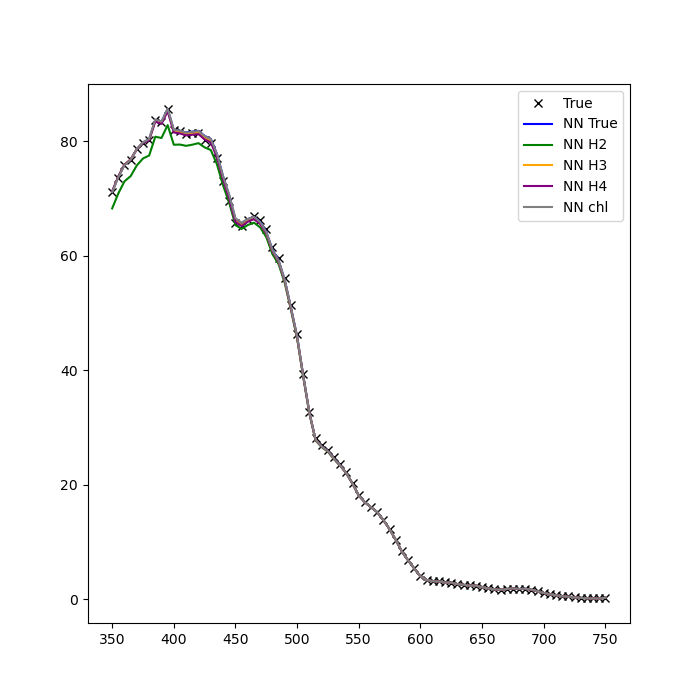

In [42]:
fig = plt.figure(figsize=(7,7))
ax_R = plt.gca()

ax_R.plot(wave, Rs[idx], 'kx', label='True')
ax_R.plot(wave, NN_Rs, 'b-', label='NN True')
ax_R.plot(wave, NN_Rs_H2, 'g-', label='NN H2')
ax_R.plot(wave, NN_Rs_H3, '-', color='orange', label='NN H3')
ax_R.plot(wave, NN_Rs_H4, '-', color='purple', label='NN H4')
#ax_R.plot(wave, NN_Rs_H5, '-', color='cyan', label='NN H5')
#
#ax_R.plot(wave, NN_Rs_bb2, '-', color='pink', label='NN bb2')
# Chl
ax_R.plot(wave, NN_Rs_chl, '-', color='gray', label='NN chl')
#if true_only:
#    pass
#elif use_quick:
#    ax_R.plot(wave, obs_Rs[0], 'bs', label='"Observed"')
#else:
#    ax_R.plot(wave, obs_Rs[in_idx], 'bs', label='"Observed"')
#ax_R.plot(wave, pred_Rs, 'r-', label='Fit', zorder=10)
#
ax_R.legend()
plt.show()

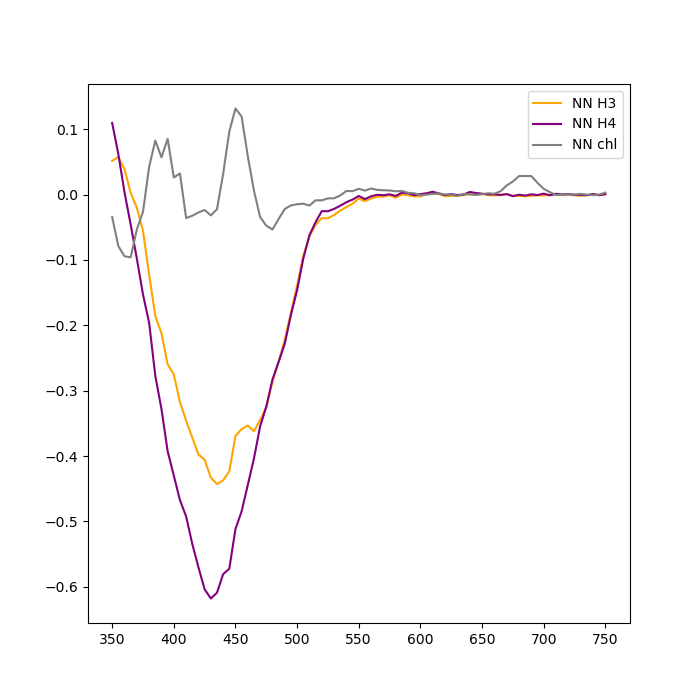

In [43]:
fig = plt.figure(figsize=(7,7))
ax_R = plt.gca()

#ax_R.plot(wave, Rs[idx], 'kx', label='True')
#ax_R.plot(wave, NN_Rs-Rs[idx], 'b-', label='NN True')
#ax_R.plot(wave, NN_Rs_H2-NN_Rs, 'g-', label='NN H2')
ax_R.plot(wave, 1.1*(NN_Rs_H3-NN_Rs), '-', color='orange', label='NN H3')
ax_R.plot(wave, NN_Rs_H4-NN_Rs, '-', color='purple', label='NN H4')
#ax_R.plot(wave, NN_Rs_H5-NN_Rs, '-', color='cyan', label='NN H5')
#
#ax_R.plot(wave, NN_Rs_bb2-NN_Rs, '-', color='pink', label='NN bb2')
# Chl
ax_R.plot(wave, NN_Rs_chl-NN_Rs, '-', color='gray', label='NN chl')
#
ax_R.legend()
plt.show()

## 